In [38]:
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [39]:
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)

In [40]:
df

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879
6,No,Yes,919.588530,7491.558572
7,No,No,825.513331,24905.226578
8,No,Yes,808.667504,17600.451344
9,No,No,1161.057854,37468.529288
10,No,No,0.000000,29275.268293


2) Convert `default` and `student` to categorical variables.

In [41]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_default.columns=['defaultNo','defaultYes']
df_student.columns=['studentNo','studentYes']
df_final = pd.concat([df[['balance','income']],df_default,df_student],axis=1)

In [42]:
df_final

,balance,income,defaultNo,defaultYes,studentNo,studentYes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0
6,919.588530,7491.558572,1,0,0,1
7,825.513331,24905.226578,1,0,1,0
8,808.667504,17600.451344,1,0,0,1
9,1161.057854,37468.529288,1,0,1,0
10,0.000000,29275.268293,1,0,1,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

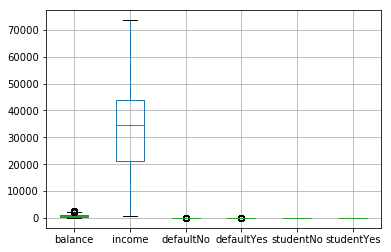

In [44]:
df_final.boxplot()

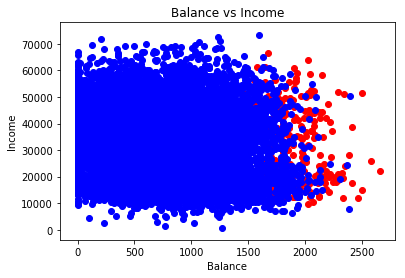

In [49]:
import pylab as plt
plt.title('Balance vs Income')
df_default = df_final[df_final['defaultYes']==1]
df_non_default = df_final[df_final['defaultNo']==1]
plt.scatter(df_default['balance'],df_default['income'],color='red')
plt.scatter(df_non_default['balance'],df_non_default['income'],color='blue')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.figure()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 